In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/DataScience/Spleen'
!ls

/content/drive/MyDrive/DataScience/Spleen
2D_Segmentation  3D_Spleen.zip	       NoteBooks
2D_Spleen.zip	 MONAI_DATA_DIRECTORY  Task09_Spleen


In [4]:
import os
import glob
from sklearn.utils import shuffle
from tqdm import tqdm_notebook
import pandas as pd
import numpy as np
import nibabel as nib
from scipy.ndimage import gaussian_filter as gf
from scipy import ndimage

# zip files : 

In [ ]:
!zip -r "/content/drive/MyDrive/DataScience/Spleen/Task09_Spleen/2D_Spleen.zip" "/content/drive/MyDrive/DataScience/Spleen/Task09_Spleen/2D_Spleen"

	zip warning: name not matched: /content/drive/MyDrive/DataScience/Spleen/Task09_Spleen/2D_Spleen

zip error: Nothing to do! (try: zip -r /content/drive/MyDrive/DataScience/Spleen/Task09_Spleen/2D_Spleen.zip . -i /content/drive/MyDrive/DataScience/Spleen/Task09_Spleen/2D_Spleen)


# Unzip

In [ ]:
import shutil
shutil.unpack_archive("2D_Spleen.zip", "2D_Segmentation")

# install segmentation models - pytorch

In [5]:
# !pip -q install monai
# !pip -q install 'monai[all]'
# !pip install segmentation-models-pytorch
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-nkgapg00
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-nkgapg00
     |████████████████████████████████| 58 kB 4.5 MB/s 
     |████████████████████████████████| 376 kB 16.0 MB/s 
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.2.0-py3-none-any.whl size=88682 sha256=03e97c69716bdec6055f447c9fc3b6dbae97f95dc5bf29d31091614c94acf159
  Stored in directory: /tmp/pip-ephem-wheel-cache-py0b_vqs/wheels/fa/c5/a8/1e8af6cb04a0974db8a4a156ebd2fdd1d99ad2558d3fce49d4
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=0586aa428cd5deb5b04ca164d6bdbd59d77974c32a5b2bb3ed4d5aa289293655
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-n

In [6]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
# from monai import transforms
# from monai.config import print_config
from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
from albumentations.torch import ToTensor
# from monai.metrics import compute_roc_auc
import sys
import glob

# Random split train & test

In [6]:
from sklearn.model_selection import train_test_split

train_subject,test_subject = train_test_split(np.arange(1,51,1), test_size=0.2, random_state=0)

train_slices = []
for i in train_subject:
  train_slices += glob.glob(f'/content/drive/MyDrive/DataScience/Spleen/2D_Segmentation/2D_Spleen/imagesTr/{i}*.npz')

test_slices = []
for i in test_subject:
  test_slices += glob.glob(f'/content/drive/MyDrive/DataScience/Spleen/2D_Segmentation/2D_Spleen/imagesTr/{i}*.npz')
test_slices = sorted(test_slices)
train_length = len(train_slices)
test_length = len(test_slices)

In [57]:
from sklearn.model_selection import train_test_split

train_subject,test_subject = train_test_split(np.arange(1,51,1), test_size=0.2, random_state=0)

train_slices = []
for i in train_subject:
  train_slices += glob.glob(f'/content/drive/MyDrive/DataScience/Spleen/2D_Segmentation/2D_Spleen/imagesTr/{i}*.npz')

test_slices = []
test_slices_per_subject = []
for i in test_subject:
  slices = glob.glob(f'/content/drive/MyDrive/DataScience/Spleen/2D_Segmentation/2D_Spleen/imagesTr/{i}*.npz')
  test_slices_per_subject.append(slices)
  test_slices += slices

test_slices = sorted(test_slices)
train_length = len(train_slices)
test_length = len(test_slices)

In [58]:
len(test_slices)

1403

In [60]:
test_slices_per_subject[0]

['/content/drive/MyDrive/DataScience/Spleen/2D_Segmentation/2D_Spleen/imagesTr/29_000.npz',
 '/content/drive/MyDrive/DataScience/Spleen/2D_Segmentation/2D_Spleen/imagesTr/29_001.npz',
 '/content/drive/MyDrive/DataScience/Spleen/2D_Segmentation/2D_Spleen/imagesTr/29_002.npz',
 '/content/drive/MyDrive/DataScience/Spleen/2D_Segmentation/2D_Spleen/imagesTr/29_003.npz',
 '/content/drive/MyDrive/DataScience/Spleen/2D_Segmentation/2D_Spleen/imagesTr/29_004.npz',
 '/content/drive/MyDrive/DataScience/Spleen/2D_Segmentation/2D_Spleen/imagesTr/29_005.npz',
 '/content/drive/MyDrive/DataScience/Spleen/2D_Segmentation/2D_Spleen/imagesTr/29_006.npz',
 '/content/drive/MyDrive/DataScience/Spleen/2D_Segmentation/2D_Spleen/imagesTr/29_007.npz',
 '/content/drive/MyDrive/DataScience/Spleen/2D_Segmentation/2D_Spleen/imagesTr/29_008.npz',
 '/content/drive/MyDrive/DataScience/Spleen/2D_Segmentation/2D_Spleen/imagesTr/29_009.npz',
 '/content/drive/MyDrive/DataScience/Spleen/2D_Segmentation/2D_Spleen/imagesTr/2

# Distribution of masks

In [ ]:
def get_distribution_vector(slices) :
  values = []
  length = len(slices)
  for i in range(length):
    img = np.load(slices[i])['img']
    mask =np.load(slices[i].replace('imagesTr','labelsTr'))['img']
    D = np.where(mask != False)
    l = len(D[1])
    for j in range(l):
      values.append(img[D[0][j],D[1][j]])
  return values 

In [ ]:
values = get_distribution_vector(train_slices)

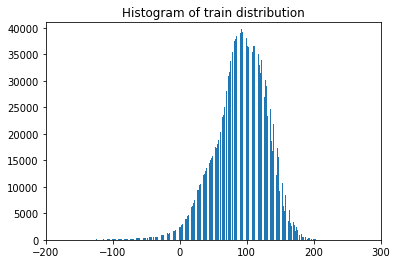

In [ ]:
import matplotlib.pyplot as plt
h = plt.hist(values, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram of train distribution")
plt.axis([-200, +300, 0, 41000])
plt.show()

In [ ]:
valmean = np.mean(values)
valstd = np.std(values)
valmean,valstd

(91.03716526460153, 40.62940675151412)

###image values in mask area :
    train slices :
      mean : 91.037
      std  : 40.629
    test slices :
      mean : 
      std  :

In [61]:
valmean = 91.03716526460153
valstd = 40.62940675151412

In [62]:
def window(img, WL=valmean, WW=6*valstd):
    upper, lower = WL+WW//2, WL-WW//2
    X = np.clip(img.copy(), lower, upper)
    X = X - np.min(X)
    X = X / (np.max(X)/255.0)
    X = cv2.merge([X,X,X])
    X = X.astype('uint8')
    return X

# Visualize a sample slice

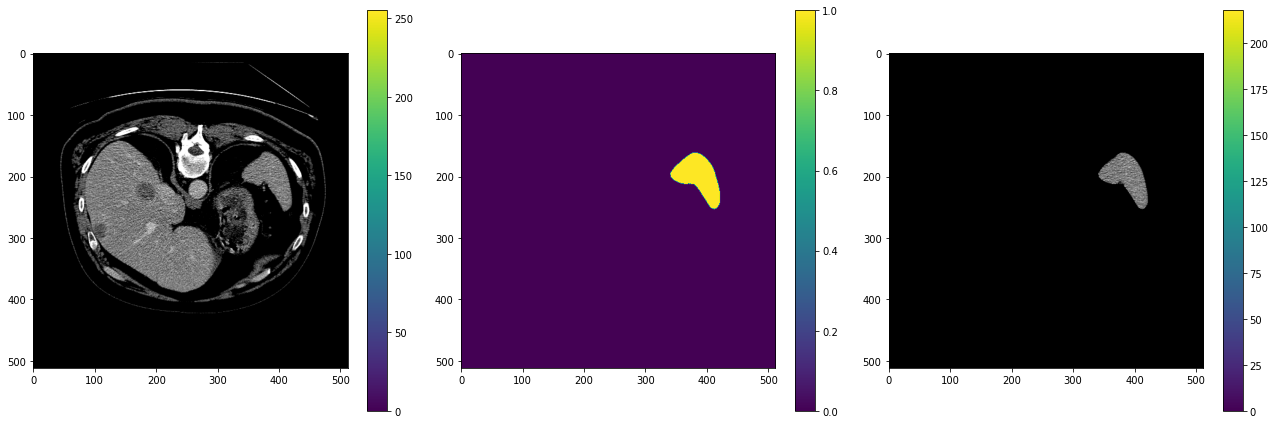

In [31]:
#i = 2607
#i = 950
i = 95
img = np.load(train_slices[i])['img']

mask =np.load(train_slices[i].replace('imagesTr','labelsTr'))['img']


slice_img = window(img)
slice_mask = mask
masked = np.array(slice_img)
masked[slice_mask==0]=0

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.imshow(slice_img)
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(slice_mask)
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(masked)
plt.colorbar()

plt.tight_layout()
plt.show()

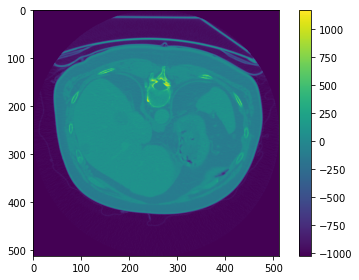

In [32]:
plt.imshow(img)
plt.colorbar()
plt.tight_layout()
plt.show()

# Augmentation

In [63]:
def get_transforms(phase, size, mean, std):
    list_transforms = []
    if phase == "train":
        list_transforms.extend(
            [
                HorizontalFlip(),
                ShiftScaleRotate(
                    shift_limit=0,  # no resizing
                    scale_limit=0.1,
                    rotate_limit=10, # rotate
                    p=0.5,
                    border_mode=cv2.BORDER_CONSTANT
                ),
#                 GaussNoise(),
            ]
        )
    list_transforms.extend(
        [
            Resize(size, size),
            Normalize(mean=mean, std=std, p=1),
            ToTensor() #in pytorch, every thing must be a tensor before giving it to model
        ]
    )
    list_trfms = Compose(list_transforms)
    return list_trfms

In [71]:
class CustomDataSet(Dataset):
    def __init__(self, files_list, size, mean, std, phase):
        self.size = size
        self.mean = mean
        self.std = std
        self.phase = phase
        self.transforms = get_transforms(phase, size, mean, std)
        self.fnames = files_list

    def __getitem__(self, idx):
        image_path = self.fnames[idx]
        image = window(np.load(image_path)['img'])
        image = image.astype(float)
        mask = np.load(image_path.replace('imagesTr','labelsTr'))['img']
        mask = mask.astype(float)

        augmented = self.transforms(image=image, mask=mask)
        image = augmented['image']
        mask = augmented['mask']
        return image, mask

    def get_image(self, path):
        image = window(np.load(path)['img'])
        image = image.astype(float)
        mask = np.load(path.replace('imagesTr','labelsTr'))['img']
        mask = mask.astype(float)

        augmented = self.transforms(image=image, mask=mask)
        image = augmented['image']
        mask = augmented['mask']
        return image, mask


    def __len__(self):
        return len(self.fnames)

# calculating mean and std
(it was not necessary)

In [72]:
i = 95
img = np.load(train_slices[i])['img']
mask =np.load(train_slices[i].replace('imagesTr','labelsTr'))['img']

win_img = window(img)
np.where(win_img !=0 )
win_img[511][511]

array([0, 0, 0], dtype=uint8)

In [ ]:
def get_RGB_vector(slices):
  length = len(slices)
  for i in range(length):
    img = np.load(slices[i])['img']
    win_img = window(img)
    R = []
    G = []
    B = []
    for j in range(512):
      for k in range(512) :
        R.append(win_img[j][k][0])
        G.append(win_img[j][k][1])
        B.append(win_img[j][k][2])
    return R,G,B   

In [ ]:
train_R,train_G,train_B = get_RGB_vector(train_slices)

In [ ]:
mean_train_R = np.mean(train_R)
mean_train_G = np.mean(train_G)
mean_train_B = np.mean(train_B)

std_train_R = np.std(train_R)
std_train_G = np.std(train_G)
std_train_B = np.std(train_B)

In [ ]:
mean_train_R , mean_train_G ,mean_train_B

In [ ]:
std_train_R ,std_train_G, std_train_B

## Loading Data

In [73]:
phase = 'train'
size = 256
mean=(0.485, 0.456, 0.406) 
std=(0.229, 0.224, 0.225) 

batch_size=16
num_workers=1

train_ds = CustomDataSet(train_slices, size, mean, std, phase)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=num_workers)

phase='test'
val_ds = CustomDataSet(test_slices, size, mean, std, phase)
val_loader = DataLoader(val_ds, batch_size=16, num_workers=num_workers)

for batch_data in train_loader:
  print(type(batch_data))
  break

<class 'list'>


# 1. Get a batch from the dataloader
# 2. Show slices with infection segmentation in a random batch-data

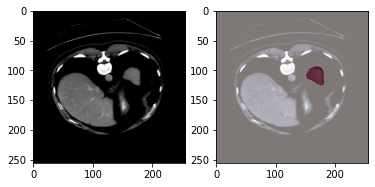

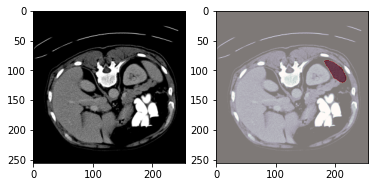

In [74]:
batch = next(iter(train_loader)) 
images, masks = batch


for idx in range(8):
  if len(np.unique(masks[idx][0])) > 1:
    plt.subplot(1,2,1)
    plt.imshow(images[idx][0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(images[idx][0], cmap='bone')
    plt.imshow(masks[idx][0], alpha=0.5, cmap='Reds')
    plt.show()

## Create Model
- standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
- use segmentation_models_pytorch 
- import unet with encoder 'resnet18'
- use 'imagenet' encoder weights
- input has 3 channels and output has 1 channel(use sigmoid activation layer for last layer)

In [ ]:
#!pip install container_abcs

In [75]:
try:
  device = torch.device("cuda:0")
  print('run with gpu')
except:
  device = torch.device("cpu")
  
import segmentation_models_pytorch as smp
n_classes = 1
activation = 'sigmoid' if n_classes == 1 else 'softmax'
model = smp.Unet(
    encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
    activation=activation
).to(device)
# error here

run with gpu


# Loss and Optimizer
- Loss = BCE + Dice_loss
- Optimizer = Adam with initial_lr = 1e-3
- lr_scheduler with CosineAnnealingLR for lr decay

In [76]:
bce_loss = torch.nn.BCELoss()

def dice_loss(pred,target):
    numerator = 2 * torch.sum(pred * target)
    denominator = torch.sum(pred + target)
    return  1 - (numerator + 1) / (denominator + 1)

def bce_dice_loss(pred,target):
  return bce_loss(pred,target) + dice_loss(pred,target)

loss_function = bce_dice_loss

optimizer = torch.optim.Adam(model.parameters(), 1e-3,weight_decay=0)

epoch_num = 20
val_interval = 1

steps = epoch_num#int(len(train_slices)/batch_size)+1
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, steps)

# Define custom metric

In [77]:
from torch.autograd import Variable

def my_dice(y_pred,y_true,device='cpu',thr=0.5):
    thr = Variable(torch.Tensor([thr])).to(device)  
    y_pred = (y_pred > thr).float() * 1
    smooth = 1e-4
    iflat = y_pred.view(-1)
    tflat = y_true.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

# Execute a typical PyTorch training process

In [ ]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
for epoch in range(epoch_num):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:

        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = 1+(len(train_ds) // train_loader.batch_size)

        sys.stdout.write('\r'+f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)

    print('\n',f"###### epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            dice_metric = my_dice(y_pred, y,device=device,thr=0.5)
            metric_values.append(dice_metric)
            if dice_metric > best_metric:
                best_metric = dice_metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), 'best_metric_model.pth')
                print('###### Congratulations ###### saved new best metric model')
            print(f"current epoch: {epoch + 1} current DICE: {dice_metric:.4f}"
                  f" at epoch: {best_metric_epoch}")
        scheduler.step()
        print('The learning rate updated to :',scheduler.get_lr()[0])
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

----------
epoch 1/20


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


246/246, train_loss: 0.3727
 ###### epoch 1 average loss: 0.8575
###### Congratulations ###### saved new best metric model
current epoch: 1 current DICE: 0.6976 at epoch: 1
The learning rate updated to : 0.000987726234834463
----------
epoch 2/20


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:509: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


246/246, train_loss: 0.1458
 ###### epoch 2 average loss: 0.2450
current epoch: 2 current DICE: 0.5827 at epoch: 1
The learning rate updated to : 0.0009575498965391206
----------
epoch 3/20
246/246, train_loss: 0.3563
 ###### epoch 3 average loss: 0.5374
current epoch: 3 current DICE: 0.0000 at epoch: 1
The learning rate updated to : 0.0009164023811348203
----------
epoch 4/20
246/246, train_loss: 0.1050
 ###### epoch 4 average loss: 0.3595
###### Congratulations ###### saved new best metric model
current epoch: 4 current DICE: 0.7518 at epoch: 4
The learning rate updated to : 0.0008652911674490296
----------
epoch 5/20
246/246, train_loss: 0.1040
 ###### epoch 5 average loss: 0.2098
current epoch: 5 current DICE: 0.7170 at epoch: 4
The learning rate updated to : 0.000805468818544741
----------
epoch 6/20
246/246, train_loss: 0.2953
 ###### epoch 6 average loss: 0.1573
###### Congratulations ###### saved new best metric model
current epoch: 6 current DICE: 0.9170 at epoch: 6
The learni

In [79]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
for epoch in range(epoch_num):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:

        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = 1+(len(train_ds) // train_loader.batch_size)

        sys.stdout.write('\r'+f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)

    print('\n',f"###### epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    with torch.no_grad():
      dice_metric=0
      for subject in test_slices_per_subject:
        #print("subject",subject)
        #print("subject length",len(subject))
        y_pred = torch.tensor([], dtype=torch.float32, device=device)
        y = torch.tensor([], dtype=torch.long, device=device)  
        for x in subject:
          #print(x)
          #print(type(x))
          val_image, val_label = val_ds.get_image(x)
          val_image, val_label= val_image.cuda(), val_label.cuda()
          y_pred= torch.cat((y_pred, model(val_image[None,...])),0)
          y= torch.cat((y, val_label), 0)
        dice_metric = dice_metric+my_dice(y_pred, y,device=device,thr=0.5)
      
      dice_metric = dice_metric/len(test_subject)
      metric_values.append(dice_metric)
      if dice_metric > best_metric:
          best_metric = dice_metric
          best_metric_epoch = epoch + 1
          torch.save(model.state_dict(), 'best_metric_model.pth')
          print('###### Congratulations ###### saved new best metric model')
      print(f"current epoch: {epoch + 1} current DICE: {dice_metric:.4f}"
              f" at epoch: {best_metric_epoch}")
    scheduler.step()
    print('The learning rate updated to :',scheduler.get_lr()[0])
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

----------
epoch 1/20
246/246, train_loss: 0.9936
 ###### epoch 1 average loss: 0.2894
###### Congratulations ###### saved new best metric model
current epoch: 1 current DICE: 0.5492 at epoch: 1
The learning rate updated to : 0.0009575498965391206
----------
epoch 2/20


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:509: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


246/246, train_loss: 0.0769
 ###### epoch 2 average loss: 0.2132
###### Congratulations ###### saved new best metric model
current epoch: 2 current DICE: 0.8110 at epoch: 2
The learning rate updated to : 0.0009164023811348203
----------
epoch 3/20
246/246, train_loss: 0.1813
 ###### epoch 3 average loss: 0.1602
current epoch: 3 current DICE: 0.7623 at epoch: 2
The learning rate updated to : 0.0008652911674490296
----------
epoch 4/20
246/246, train_loss: 0.1500
 ###### epoch 4 average loss: 0.1378
###### Congratulations ###### saved new best metric model
current epoch: 4 current DICE: 0.8705 at epoch: 4
The learning rate updated to : 0.000805468818544741
----------
epoch 5/20
246/246, train_loss: 0.0338
 ###### epoch 5 average loss: 0.1067
###### Congratulations ###### saved new best metric model
current epoch: 5 current DICE: 0.8882 at epoch: 5
The learning rate updated to : 0.0007384019661749497
----------
epoch 6/20
246/246, train_loss: 0.2194
 ###### epoch 6 average loss: 0.1586
cu

## Plot the loss and metric

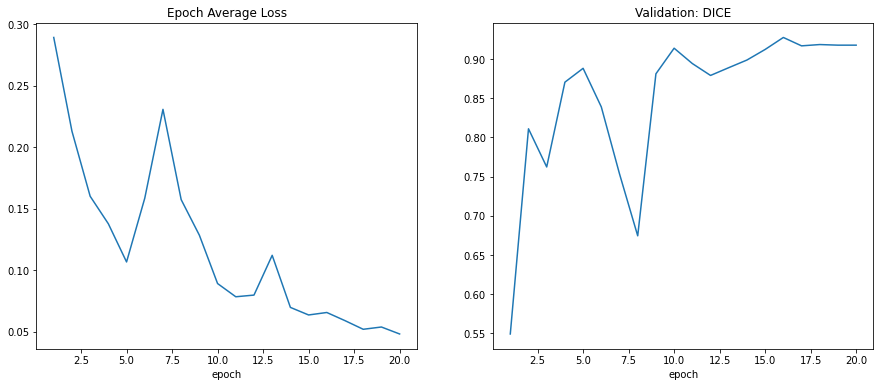

In [80]:
plt.figure('train', (15, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Validation: DICE")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.show()

## Check best model output with the input slice and label

In [81]:
model.load_state_dict(torch.load('best_metric_model.pth'))
model.eval()
y_true = list()
y_pred = list()
# y_new_pred = list()
with torch.no_grad():
    for val_data in val_loader:
        test_images, test_labels = val_data[0].to(device), val_data[1].to(device)
        pred = model(test_images)
        # new_pred = pred.argmax(dim=1)

        for i in range(len(pred)):
            y_true.append(test_labels[i].cpu().detach().numpy())
            y_pred.append(pred[i].cpu().detach().numpy())
            # y_new_pred.append(new_pred[i].cpu().detach().numpy())

In [82]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_true.shape,y_pred.shape

((1403, 1, 256, 256), (1403, 1, 256, 256))

          Raw Images        ,       True Mask(green)      ,   Prediction Mask(Red)


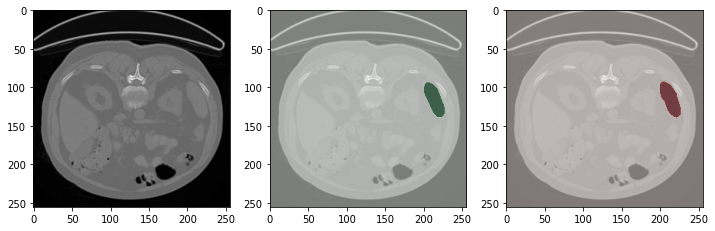

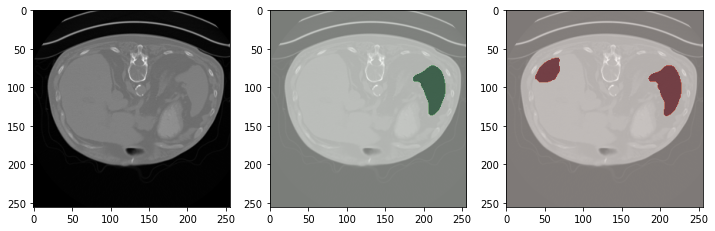

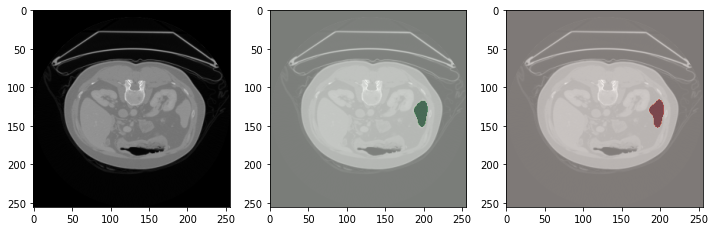

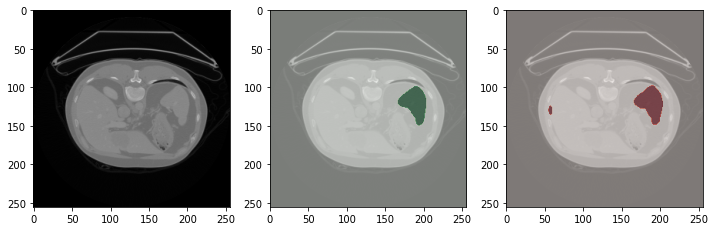

In [85]:
n_sample = 8

samples = np.random.randint(0,760,n_sample)

images, masks, predict = [],[],[]
for sample in samples:
  images.append(cv2.resize(np.load(np.array(test_slices)[sample])['img'],(size,size)))
  masks.append(y_true[sample,0])
  predict.append(y_pred[sample,0]>0.5)

print('          Raw Images        ,       True Mask(green)      ,   Prediction Mask(Red)')
for idx in range(n_sample):
  if np.sum(masks[idx])+np.sum(predict[idx]) > 10:
    plt.figure(figsize=(12,36))
    plt.subplot(1,3,1)
    plt.imshow(images[idx], cmap='gray')
    plt.subplot(1,3,2)
    plt.imshow(images[idx], cmap='gray')
    plt.imshow(masks[idx], alpha=0.5, cmap='Greens')
    plt.subplot(1,3,3)
    plt.imshow(images[idx], cmap='gray')
    plt.imshow(predict[idx], alpha=0.5, cmap='Reds')
    plt.show()

In [ ]:
!nvidia-smi

Sat Jun 19 17:01:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------